In [2]:
import pandas as pd
import os
from tensorflow import keras
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve
from keras import layers

import matplotlib.pyplot as plt
import numpy as np
import tensorflow_hub as hub
import math
import tensorflow as tf
import cv2
# permitir que tensor flow solo muestre logs de errores graves
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


# Data augmentation

In [15]:
# carga del archivo .csv con la metadata
metadata = pd.read_csv("./metadata.csv")
metadata.head()

,image_name,diagnosis,patient_id,sex,age_approx,anatom_site_general_challenge,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,unknown,IP_7279968,male,45.0,head/neck,benign,0,0,6000,4000
1,ISIC_0015719,unknown,IP_3075186,female,45.0,upper extremity,benign,0,0,6000,4000
2,ISIC_0052212,nevus,IP_2842074,female,50.0,lower extremity,benign,0,6,1872,1053
3,ISIC_0068279,unknown,IP_6890425,female,45.0,head/neck,benign,0,0,1872,1053
4,ISIC_0074268,unknown,IP_8723313,female,55.0,upper extremity,benign,0,11,6000,4000


In [2]:
# Selección de directorio a los datos
img_dir = "data/128x128/img/" # reescalar 64x64
# Ruta de datos de entrenamiento, testeo y validación
train = "data/train/"
test = "data/test/"
validation = "data/validation/"

In [3]:
# almacenando la cantidad de imagenes de entrenamiento, testing y validacion
train_positive = glob(train+'positive/*.jpg')
train_negative = glob(train+'negative/*.jpg')
train_total_img = len(train_positive) + len(train_negative)

test_positive = glob(test+'positive/*.jpg')
test_negative = glob(test+'negative/*.jpg')
test_total_img = len(test_positive) + len(test_negative)

validation_positive = glob(validation+'positive/*.jpg')
validation_negative = glob(validation+'negative/*.jpg')
validation_total_img = len(validation_positive) + len(validation_negative)

print('Imágenes de entrenamiento: ',train_total_img,'\n Positivas: ',len(train_positive),'\n Negativas: ',len(train_negative))
print('Imágenes de testeo: ',test_total_img,'\n Positivas: ',len(test_positive),'\n Negativas: ',len(test_negative))
print('Imágenes de validación: ',validation_total_img,'\n Positivas: ',len(validation_positive),'\n Negativas: ',len(validation_negative))

Imágenes de entrenamiento:  26426 
 Positivas:  473 
 Negativas:  25953
Imágenes de testeo:  3407 
 Positivas:  55 
 Negativas:  3352
Imágenes de validación:  3293 
 Positivas:  56 
 Negativas:  3237


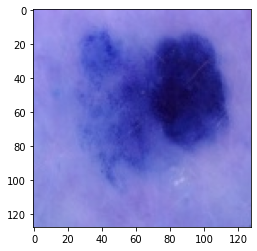

In [17]:
img_bgr = cv2.imread(train_negative[32])
plt.imshow(img_bgr)

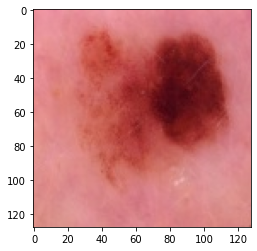

In [18]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

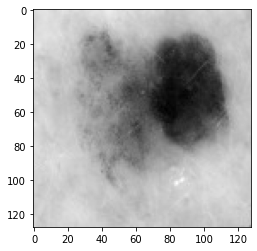

In [19]:
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='gray')

In [20]:
img_gray.shape, len(train_negative)//len(train_positive)

((128, 128), 54)

In [87]:
# tamaño de las imágenes
img_height = img_width = img_gray.shape[0]
# número de muestras que se propagarán a través de la red
batch_size = len(train_negative)//len(train_positive) # porcion de las imagenes pre train default 32 ~ 2^n


In [90]:
# Funciones de transformación a los datos de training, testing y validation 

train_data_generator = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    zoom_range=(0.95, 0.95),
    horizontal_flip=True,
    vertical_flip=True,
    data_format='channels_last', # (ROW, COL, CHANNEL)
    
)

validation_data_generator = ImageDataGenerator(
    rescale=1.0/255,
    dtype=tf.float32
)

test_data_generator = ImageDataGenerator(
    rescale=1.0/255,
    dtype=tf.float32
)


In [91]:
# contantes que almacenarán las imágenes y sus transformaciones 
train_generate = train_data_generator.flow_from_directory(
    train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='binary',
    shuffle=True,
    seed=1
)

validation_generate = validation_data_generator.flow_from_directory(
    validation,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='binary',
    shuffle=True,
    seed=1
)

test_generate = test_data_generator.flow_from_directory(
    test,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='binary',
    shuffle=True,
    seed=1
)


Found 26426 images belonging to 2 classes.
Found 3293 images belonging to 2 classes.
Found 3407 images belonging to 2 classes.


In [ ]:
# NasNet modelo seleccionado, basado en ResNet50, recurso online
# activation soft max
model = keras.Sequential([ # vgg16
    hub.KerasLayer(
        "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/5", trainable=True),
    layers.Dense(1, activation="sigmoid")
])

In [89]:
# NasNet modelo seleccionado, basado en ResNet50, recurso local
model = keras.Sequential([
    hub.KerasLayer(
        "model/imagenet_nasnet_mobile_feature_vector_5", trainable=True),
    layers.Dense(1, activation="sigmoid")

])

In [92]:
METRICS = [ 
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"), # redondear 
    keras.metrics.AUC (name="auc"),
]

In [94]:
# proceso de entrenamiento y validación del modelo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4), # 1e-4~5
    loss=[keras.losses.BinaryCrossentropy(from_logits=False)], # numero de clases 
    metrics=METRICS
)

model.fit(
    train_generate,
    epochs=3, # 10, **4
    verbose=1,
    steps_per_epoch=train_total_img//batch_size,
    validation_steps=validation_total_img//batch_size,
    validation_data=validation_generate,
    callbacks=[keras.callbacks.ModelCheckpoint('model/train_nasnet')]
)


Epoch 1/3
INFO:tensorflow:Assets written to: model\train_nasnet\assets


INFO:tensorflow:Assets written to: model\train_nasnet\assets


489/489 - 3034s - loss: 0.4769 - accuracy: 0.9774 - precision: 0.0373 - recall: 0.0106 - auc: 0.7880 - val_loss: 0.4539 - val_accuracy: 0.9830 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8455 - 3034s/epoch - 6s/step
Epoch 2/3
INFO:tensorflow:Assets written to: model\train_nasnet\assets


INFO:tensorflow:Assets written to: model\train_nasnet\assets


489/489 - 2472s - loss: 0.4481 - accuracy: 0.9821 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8579 - val_loss: 0.4409 - val_accuracy: 0.9827 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8520 - 2472s/epoch - 5s/step
Epoch 3/3
INFO:tensorflow:Assets written to: model\train_nasnet\assets


INFO:tensorflow:Assets written to: model\train_nasnet\assets


489/489 - 2809s - loss: 0.4284 - accuracy: 0.9821 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8950 - val_loss: 0.4325 - val_accuracy: 0.9827 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8049 - 2809s/epoch - 6s/step


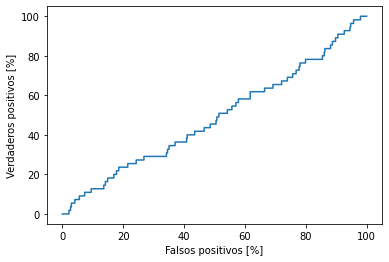

In [96]:
def plot_roc(labels, data):
    predictions = model.predict(data)
    fp, tp, _ = roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp)
    plt.xlabel("Falsos positivos [%]")
    plt.ylabel("Verdaderos positivos [%]")
    plt.show()
    
test_labels = np.array([])
num_batches = 0
for _, y in test_generate:
    test_labels = np.append(test_labels, y)
    num_batches += 1
    if num_batches == math.ceil(test_total_img / batch_size):
        break
    
plot_roc(test_labels, test_generate)

In [97]:
model.evaluate(validation_generate, verbose=1)
model.evaluate(test_generate, verbose=1)

61/61 - 129s - loss: 0.4313 - accuracy: 0.9830 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8045 - 129s/epoch - 2s/step
64/64 - 145s - loss: 0.4228 - accuracy: 0.9839 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8679 - 145s/epoch - 2s/step


[0.4228097200393677, 0.983856737613678, 0.0, 0.0, 0.8678591251373291]